In [12]:
import pandas as pd
title_akas_data = pd.read_csv('title.akas.tsv', sep = '\t', nrows= 10000)
title_basic_data = pd.read_csv('title.basics.tsv', sep = '\t', nrows= 10000)
title_ratings_data = pd.read_csv('title.ratings.tsv', sep = '\t', nrows= 10000)
title_episode_data = pd.read_csv('title.episode.tsv', sep = '\t', nrows= 10000)
title_principals_data = pd.read_csv('title.principals.tsv', sep = '\t', nrows= 10000)
name_basics_data = pd.read_csv('name.basics.tsv', sep = '\t', nrows= 10000)

# title_principals_data = pd.read_csv('title.principals.tsv', sep = '\t', nrows= 10000)
# title_crew_data = pd.read_csv('title.crew.tsv', sep = '\t', nrows= 10000)

# print(name_basic_data)
# print(title_episode_data)
# print(title_principals_data)
# print(title_ratings_data)
# print(title_crew_data)

"""
Data Parsing
"""
# parse type data
type_data_set = set(title_akas_data['types'])
type_data = pd.DataFrame(list(type_data_set), columns = ['name'])

# parse attribute data
attribute_data_set = set(title_akas_data['attributes'])
attribute_data = pd.DataFrame(list(attribute_data_set), columns = ['name'])


# parse genre data
genre_data_raw = title_basic_data['genres']
genre_data_set = set()
for data in genre_data_raw:
    data = data.split(",")
    for item in data:
        if item:
            genre_data_set.add(item)
genre_data = pd.DataFrame(list(genre_data_set), columns = ['name'])

# parse title_basic data
title_basics = pd.DataFrame(title_basic_data, columns=['tconst', 'titleType', 'primaryTitle', 'originalTitle', 'isAdult', 'startYear', 'endYear', 'runtimeMinutes'])


# parse title_aka data
title_akas = pd.DataFrame(title_akas_data, columns=['titleId', 'ordering', 'title', 'region', 'language', 'isOriginalTitle'])

# parse title_ratings data
title_ratings = pd.DataFrame(title_ratings_data, columns=['tconst', 'averageRating', 'numVotes'])

# parse title_episode data
title_episode = pd.DataFrame(title_episode_data, columns=['tconst', 'parentTconst', 'seasonNumber', 'episodeNumber'])

# parse title_principals data
title_principals = pd.DataFrame(title_principals_data, columns=['tconst', 'ordering', 'category', 'job', 'characters'])

# parse name_basics data
name_basics = pd.DataFrame(name_basics_data, columns=['nconst', 'primaryName', 'birthYear', 'deathYear'])

# parse profession data
profession_data_raw = name_basics_data['primaryProfession']
profession_data_set = set()
for data in profession_data_raw:
    data = str(data).split(",")
    for item in data:
        if item:
            profession_data_set.add(item)
profession_data = pd.DataFrame(list(profession_data_set), columns = ['name'])
# print(profession_data)





         tconst parentTconst seasonNumber episodeNumber
0     tt0041951    tt0041038            1             9
1     tt0042816    tt0989125            1            17
2     tt0042889    tt0989125           \N            \N
3     tt0043426    tt0040051            3            42
4     tt0043631    tt0989125            2            16
...         ...          ...          ...           ...
9995  tt0439235    tt0463399            9            25
9996  tt0439247    tt0463399            9            28
9997  tt0439308    tt0239195            6            15
9998  tt0439338    tt3776668            3             3
9999  tt0439420    tt0092322           \N            \N

[10000 rows x 4 columns]


In [3]:
import sqlite3

""""
Connect with database
"""
con_db = sqlite3.connect('mydb.db')

"""
Create Tables
"""

# Create type table
con = con_db.cursor()
con.execute('''
            CREATE TABLE IF NOT EXISTS type (
            "name" varchar(255),
            PRIMARY KEY (name)
            );
            ''')
con.close()

# Create attribute table
con = con_db.cursor()
con.execute('''
            CREATE TABLE IF NOT EXISTS attribute(
            name VARCHAR(255),
            PRIMARY KEY (name)
            );
            ''')
con.close()

# create type_title table
con = con_db.cursor()
con.execute('''
            CREATE TABLE IF NOT EXISTS type_title (
            name VARCHAR(255),
            tconst VARCHAR(255),
            PRIMARY KEY (name, tconst),
            FOREIGN KEY (name) REFERENCES type(name),
            FOREIGN KEY (tconst) REFERENCES title_akas(tconst)
            );
            ''')
con.close()

# create title_akas table
con = con_db.cursor()
con.execute('''
            CREATE TABLE IF NOT EXISTS title_akas(
            tconst VARCHAR(255),
            ordering INT,
            title VARCHAR(255),
            region VARCHAR(255),
            language VARCHAR(255),
            isOriginalTitle INT,
            PRIMARY KEY (tconst, ordering),
            FOREIGN KEY (tconst) REFERENCES title_basics(tconst)
            );
            ''')
con.close()

# create akas_attributes table
con = con_db.cursor()
con.execute('''
            CREATE TABLE IF NOT EXISTS akas_attributes(
            tconst VARCHAR(255),
            name VARCHAR(255),
            PRIMARY KEY (tconst, name),
            FOREIGN KEY (tconst) REFERENCES title_akas(tconst),
            FOREIGN KEY (name) REFERENCES attribute(name)
            );
            ''')
con.close()

# create title_ratings table
con = con_db.cursor()
con.execute('''
            CREATE TABLE IF NOT EXISTS title_ratings (
            tconst VARCHAR(255),
            averageRating INT,
            numVotes INT,
            PRIMARY KEY (tconst),
            FOREIGN KEY (tconst) REFERENCES title_basics(tconst)
            );
            ''')
con.close()

# create title_basics table
con = con_db.cursor()
con.execute('''
            CREATE TABLE IF NOT EXISTS title_basics (
            tconst VARCHAR(255),
            titleType VARCHAR(255),
            primaryTitle VARCHAR(255),
            originalTitle VARCHAR(255),
            isAdult INT,
            startYear VARCHAR(255),
            endYear VARCHAR(255),
            runtimeMinutes INT,
            PRIMARY KEY (tconst)
            );
            ''')
con.close()

# create genre_title table
con = con_db.cursor()
con.execute('''
            CREATE TABLE IF NOT EXISTS genre_title (
            name VARCHAR(255),
            tconst VARCHAR(255),
            PRIMARY KEY (name, tconst),
            FOREIGN KEY (name) REFERENCES genre(name),
            FOREIGN KEY (tconst) REFERENCES title_basics(tconst)
            );
            ''')
con.close()

# create title_episode table
con = con_db.cursor()
con.execute('''
            CREATE TABLE IF NOT EXISTS title_episode(
            tconst VARCHAR(255),
            parentTconst VARCHAR(255),
            seasonNumber INT,
            episodeNumber INT,
            PRIMARY KEY (tconst),
            FOREIGN KEY (tconst) REFERENCES title_basics(tconst),
            FOREIGN KEY (parentTconst) REFERENCES title_basics(tconst)
            );
            ''')
con.close()

# create title_principals table
con = con_db.cursor()
con.execute('''
            CREATE TABLE IF NOT EXISTS title_principals (
            tconst VARCHAR(255),
            ordering INT,
            category VARCHAR(255),
            job VARCHAR(255),
            characters VARCHAR(255),
            PRIMARY KEY (tconst, ordering),
            FOREIGN KEY (tconst) REFERENCES title_basics(tconst)
            );
            ''')
con.close()

# create title_position table
con = con_db.cursor()
con.execute('''
            CREATE TABLE IF NOT EXISTS title_position(
            tconst VARCHAR(255),
            nconst VARCHAR(255),
            isDirector INT,
            isWriter INT,
            PRIMARY KEY (tconst, nconst),
            FOREIGN KEY (tconst) REFERENCES title_basics(tconst),
            FOREIGN KEY (nconst) REFERENCES name_basics(nconst)
            );
            ''')
con.close()

# create name_basics table
con = con_db.cursor()
con.execute('''
            CREATE TABLE IF NOT EXISTS name_basics(
            nconst VARCHAR(255),
            primaryName VARCHAR(255),
            birthYear VARCHAR(255),
            deathYear VARCHAR(255),
            primary KEY (nconst)
            );
            ''')
con.close()

# create principal_name table
con = con_db.cursor()
con.execute('''
            CREATE TABLE IF NOT EXISTS principal_name(
            nconst VARCHAR(255),
            tconst VARCHAR(255),
            PRIMARY KEY (nconst, tconst),
            FOREIGN KEY (nconst) REFERENCES name_basics(nconst),
            FOREIGN KEY (tconst) REFERENCES title_principals(tconst)
            );
            ''')
con.close()

# create profession table
con = con_db.cursor()
con.execute('''
            CREATE TABLE IF NOT EXISTS profession (
            name VARCHAR(255),
            PRIMARY KEY (name)
            );
            ''')
con.close()

# create name_profession table
con = con_db.cursor()
con.execute('''
            CREATE TABLE IF NOT EXISTS name_profession(
            nconst VARCHAR(255),
            name VARCHAR(255),
            PRIMARY KEY (nconst, name),
            FOREIGN KEY (nconst) REFERENCES name_basics(nconst),
            FOREIGN KEY (name) REFERENCES profession(name)
            );
            ''')
con.close()

# create genre table
con = con_db.cursor()
con.execute('''
            CREATE TABLE IF NOT EXISTS genre (
            name VARCHAR(255),
            PRIMARY KEY (name)
            );
            ''')
con.close()

# create title_name table
con = con_db.cursor()
con.execute('''
            CREATE TABLE IF NOT EXISTS title_name (
            tconst VARCHAR(255),
            nconst VARCHAR(255),
            PRIMARY KEY (tconst, nconst),
            FOREIGN KEY (tconst) REFERENCES title_basics(tconst),
            FOREIGN KEY (nconst) REFERENCES name_basics(nconst)
            );
            ''')
con.close()





In [11]:
"""
INSERT data
"""

def insertInto(tableName, data, numCols):
    con = con_db.cursor()
    query = "INSERT INTO " + tableName + " VALUES (" + ",".join("?" * numCols) + " )"
    for idx, row in data.iterrows():
        # print(row)
        con.execute(query, row)
    con.close()

insertInto("type", type_data, 1)
insertInto("attribute", attribute_data, 1)
insertInto("genre", genre_data, 1)
insertInto("title_basics", title_basics, 8)
insertInto("title_akas", title_akas, 6)
insertInto("title_ratings", title_ratings, 3)
insertInto("title_episode", title_episode, 4)
insertInto("title_principals", title_principals, 5)
insertInto("name_basics", name_basics, 4)
insertInto("profession", profession_data, 1)


In [18]:
""""
Test
"""
con = con_db.cursor()
# print(pd.read_sql_query("SELECT * FROM genre", con_db))
# print(pd.read_sql_query("SELECT * FROM type", con_db))
# print(pd.read_sql_query("SELECT * FROM attribute", con_db))
# print(pd.read_sql_query("SELECT * FROM title_basics", con_db))
# print(pd.read_sql_query("SELECT * FROM title_akas", con_db))
# print(pd.read_sql_query("SELECT * FROM title_principals", con_db))
# print(pd.read_sql_query("SELECT * FROM name_basics", con_db))
# print(pd.read_sql_query("SELECT * FROM profession", con_db))
con.close()

         tconst titleType                 primaryTitle  \
0     tt0000001     short                   Carmencita   
1     tt0000002     short       Le clown et ses chiens   
2     tt0000003     short               Pauvre Pierrot   
3     tt0000004     short                  Un bon bock   
4     tt0000005     short             Blacksmith Scene   
...         ...       ...                          ...   
9995  tt0010131     movie                   Fit to Win   
9996  tt0010132     movie          Flame of the Desert   
9997  tt0010133     movie             The Follies Girl   
9998  tt0010134     movie                  Fool's Gold   
9999  tt0010135     movie  The Foolish Fish of Sawback   

                    originalTitle  isAdult startYear endYear runtimeMinutes  
0                      Carmencita        0      1894      \N              1  
1          Le clown et ses chiens        0      1892      \N              5  
2                  Pauvre Pierrot        0      1892      \N         

In [ ]:
"""
Q5 Age
"""
con = con_db.cursor()
con.execute('''
            UPDATE name_basics
            SET age = CASE
                      WHEN deathYear IS NULL THEN (strftime('%Y', 'now') - birthyear)
                                             ELSE (deathyear - birthyear)
                      END;
            ''')
con.close()

In [ ]:
"""
Q5 number of movie appears
"""
con = con_db.cursor()
con.execute('''
            UPDATE name_basics
            SET numberOfMovies = (
                                  SELECT COUNT(title_name.nconst)
                                  FROM title_name, name_basics
                                  WHERE title_name.nconst = name_basics.nconst
                                  );
            ''')
con.close()

In [ ]:
"""
Q6 Age
"""
con = con_db.cursor()
con.execute('''
            CREATE TRIGGER new_person_name
            AFTER INSERT ON name_basics
            BEGIN
                UPDATE name_basics
                SET age = CASE
                          WHEN deathYear IS NULL THEN (strftime('%Y', 'now') - birthyear)
                                             ELSE (deathyear - birthyear)
                          END;
            END;
            ''')

con.close()

In [ ]:
"""
Q6 number of movie appears
"""

In [4]:
#Test case for 7, delete before submission
con = con_db.cursor()
con.execute('''
    CREATE TABLE IF NOT EXISTS name_basics(
    nconst VARCHAR(255),
    primaryName VARCHAR(255),
    birthYear VARCHAR(255),
    deathYear VARCHAR(255),
    age INT,
    numberOfMovies INT,
    primary KEY (nconst)
    );
''')
con.close()
con = con_db.cursor()
con.execute('''
    INSERT INTO name_basics VALUES
    ('nm0000001', 'Fred Astaire', '1899', '1987', 88, 10),
    ('nm0000002', 'Brigitte Bardot', '1934', NULL, 86, 15);
''')
con.close()

OperationalError: table name_basics has 4 columns but 6 values were supplied

In [19]:
"""
7. Create a view that lists the name of each actor, their age, whether they are dead or not, and how many movies they are known for.
"""
con = con_db.cursor()
con.execute('''
    DROP VIEW IF EXISTS [Actor Data];
''')
con.close()
con = con_db.cursor()
con.execute('''
    CREATE VIEW [Actor Data] AS
    SELECT primaryname, age, 
    CASE
        WHEN deathYear is NULL THEN 'Alive'
        ELSE 'Dead'
    END AS status, numberofmovies
    FROM name_basics;
''')
con.close()
con = con_db.cursor()
con.execute('''
    SELECT * from [Actor Data];
''')
results = con.fetchall()
for result in results:
    print(f"name: {result[0]} age: {result[1]} status: {result[2]} numberOfMovies: {result[3]}")
con.close()

OperationalError: no such column: age

[('tt0039123', 1), ('tt0040049', 1), ('tt0040051', 4), ('tt0041023', 1), ('tt0041038', 1), ('tt0042094', 1), ('tt0042098', 1), ('tt0042141', 1), ('tt0043208', 1), ('tt0043228', 4), ('tt0044243', 1), ('tt0044266', 1), ('tt0044284', 2), ('tt0045395', 3), ('tt0045409', 1), ('tt0045412', 1), ('tt0045415', 1), ('tt0045449', 3), ('tt0046580', 1), ('tt0046587', 2), ('tt0046593', 29), ('tt0046617', 1), ('tt0046637', 3), ('tt0046643', 1), ('tt0047702', 2), ('tt0047707', 1), ('tt0047720', 2), ('tt0047731', 1), ('tt0047745', 2), ('tt0047756', 1), ('tt0047764', 1), ('tt0047768', 1), ('tt0048842', 1), ('tt0048845', 1), ('tt0048893', 4), ('tt0048916', 1), ('tt0049992', 1), ('tt0050013', 4), ('tt0050026', 1), ('tt0050060', 2), ('tt0050072', 1), ('tt0051312', 1), ('tt0051328', 2), ('tt0052447', 2), ('tt0052458', 1), ('tt0052466', 1), ('tt0052511', 1), ('tt0052512', 2), ('tt0053510', 1), ('tt0053546', 1), ('tt0054510', 1), ('tt0054513', 1), ('tt0054532', 1), ('tt0055657', 3), ('tt0055663', 1), ('tt0055

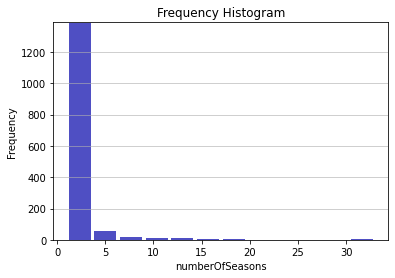

In [40]:
"""
8. (9 pts / 90 min) Write a query that finds the number of seasons for each TV series. Using the results of the query create a histogram (frequency plot).
"""
#Query
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import math
con = con_db.cursor()
# con.execute('''
#     SELECT a.primaryTitle, b.numberOfSeasons
#     FROM title_basics a, 
#     (select parenttconst, COUNT(DISTINCT seasonNumber) as numberOfSeasons
#     FROM title_episode
#     GROUP BY parenttconst) b
#     where a.tconst = b.parenttconst;
# ''')
con.execute('''
    select parenttconst, COUNT(DISTINCT seasonNumber) as numberOfSeasons
    FROM title_episode
    GROUP BY parenttconst
''')
results = con.fetchall()
print(results)
#Frequency Histogram
numberOfSeasons = []
for i in range(len(results)):
    numberOfSeasons.append(results[i][1])    
# An "interface" to matplotlib.axes.Axes.hist() method
n, bins, patches = plt.hist(x=numberOfSeasons, bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('numberOfSeasons')
plt.ylabel('Frequency')
plt.title('Frequency Histogram')
maxfreq = n.max()
# Set a clean upper y-axis limit.
plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)
con.close()

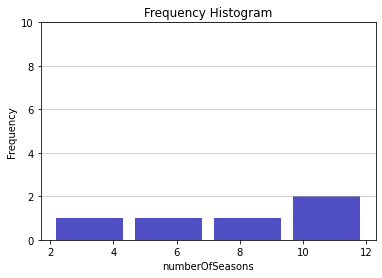

In [7]:
#Test use for 8, delete before submission
import sqlite3
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import math
""""
Connect with database
"""
con_db = sqlite3.connect('mydb.db')

con = con_db.cursor()
con.execute('''
    CREATE TABLE IF NOT EXISTS Histogram (
        primaryTitle VARCHAR(255),
        numberOfSeasons INT
    );
''')
con.close()
con = con_db.cursor()
con.execute('''
    INSERT INTO Histogram (primaryTitle, numberOfSeasons)
    VALUES ('Carmencita', 2),
           ('Blacksmith Scene', 9),
           ('Le clown et ses chiens', 10),
           ('Pauvre Pierrot', 5),
           ('Un bon bock', 12)
    ;
''')
con.close()
con = con_db.cursor()
con.execute('''
    SELECT * FROM Histogram;
''')
results = con.fetchall()
numberOfSeasons = []
for i in range(len(results)):
    numberOfSeasons.append(results[i][1])    
# An "interface" to matplotlib.axes.Axes.hist() method
n, bins, patches = plt.hist(x=numberOfSeasons, bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('numberOfSeasons')
plt.ylabel('Frequency')
plt.title('Frequency Histogram')
maxfreq = n.max()
# Set a clean upper y-axis limit.
plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)
con.close()